Use Random Forest to prepare a model on fraud data 
treating those who have taxable_income <= 30000 as "Risky" and others are "Good"

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

In [3]:
data=pd.read_csv("Fraud_check.csv")
data.head()

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO


In [4]:
data.shape

(600, 6)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Undergrad        600 non-null    object
 1   Marital.Status   600 non-null    object
 2   Taxable.Income   600 non-null    int64 
 3   City.Population  600 non-null    int64 
 4   Work.Experience  600 non-null    int64 
 5   Urban            600 non-null    object
dtypes: int64(3), object(3)
memory usage: 28.2+ KB


In [7]:
data.isnull().sum()

Undergrad          0
Marital.Status     0
Taxable.Income     0
City.Population    0
Work.Experience    0
Urban              0
dtype: int64

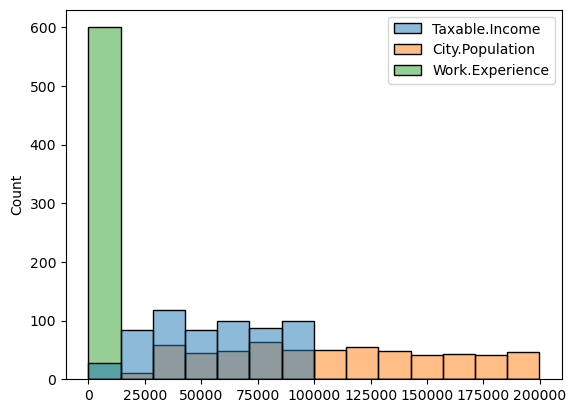

In [8]:
sns.histplot(data)
plt.show()

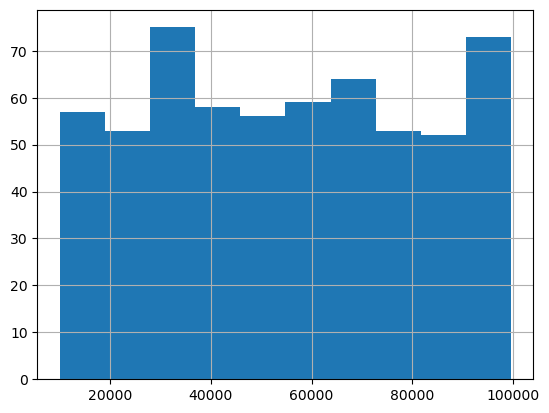

In [9]:
data["Taxable.Income"].hist()
plt.show()

In [10]:
# installing category_ encoders to convert the category to numerical

In [11]:
!pip install category_encoders

In [12]:
import category_encoders as ce

In [13]:
encoder=ce.OrdinalEncoder(cols=["Undergrad","Marital.Status","Urban"])
fraud_check=encoder.fit_transform(data)
fraud_check.head()

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,1,1,68833,50047,10,1
1,2,2,33700,134075,18,1
2,1,3,36925,160205,30,1
3,2,1,50190,193264,15,1
4,1,3,81002,27533,28,2


In [14]:
fraud_check_val=[]
for value in data['Taxable.Income']:
    if value <=30000:
        fraud_check_val.append("Risky")
    else:
        fraud_check_val.append("Good")
        
fraud_check["fc_val"]=fraud_check_val

In [15]:
fraud_check.head()

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban,fc_val
0,1,1,68833,50047,10,1,Good
1,2,2,33700,134075,18,1,Good
2,1,3,36925,160205,30,1,Good
3,2,1,50190,193264,15,1,Good
4,1,3,81002,27533,28,2,Good


In [16]:
# train and split
x=fraud_check.drop(['fc_val','Taxable.Income'],axis=1)
y=fraud_check['fc_val']

In [17]:
x

,Undergrad,Marital.Status,City.Population,Work.Experience,Urban
0,1,1,50047,10,1
1,2,2,134075,18,1
2,1,3,160205,30,1
3,2,1,193264,15,1
4,1,3,27533,28,2
...,...,...,...,...,...
595,2,2,39492,7,1
596,2,2,55369,2,1
597,1,2,154058,0,1
598,2,3,180083,17,2


In [18]:
y

0      Good
1      Good
2      Good
3      Good
4      Good
       ... 
595    Good
596    Good
597    Good
598    Good
599    Good
Name: fc_val, Length: 600, dtype: object

In [19]:
y.value_counts()

Good     476
Risky    124
Name: fc_val, dtype: int64

### Random Forest Classification

In [20]:
num_trees=100
max_features=4
Kfold=KFold(n_splits=20,shuffle=True)
model=RandomForestClassifier(n_estimators=num_trees,max_features=max_features)
results_rfc=cross_val_score(model,x,y, cv=Kfold)
print(results_rfc.mean()*100)

74.33333333333334


### Various Ensemble techiques

#### Bagging

In [21]:
from sklearn.ensemble import BaggingClassifier
kfold_1=KFold(n_splits=20,shuffle=True)
cart=DecisionTreeClassifier()
num_trees=100
model1=BaggingClassifier(base_estimator=cart,n_estimators=num_trees)
result_bag=cross_val_score(model1,x,y,cv=kfold_1)
print(result_bag.mean()*100)

72.83333333333334


#### Boosting

In [22]:
from sklearn.ensemble import AdaBoostClassifier
num_trees = 100
kfold = KFold(n_splits=20,shuffle=True)
model2= AdaBoostClassifier(n_estimators=num_trees,random_state=None)
result_boost=cross_val_score(model2,x,y,cv=kfold)
print(result_boost.mean()*100)

77.16666666666666


#### Stacking

In [23]:
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


In [24]:
# create the sub models
estimators=[]
model3=LogisticRegression(max_iter=500)
estimators.append(('Logistic',model3))
model4=DecisionTreeClassifier()
estimators.append(('cart',model4))
model5=SVC()
estimators.append(('svm',model5))


# create the ensemble model
ensemble = VotingClassifier(estimators)
result_stack=cross_val_score(ensemble,x,y,cv=kfold)
print(result_stack.mean()*100)

79.33333333333333


###### Stacking has a great accuracy 79.333%